<br>
<p style="font-size:48px;text-align:center;line-height:100%">
    A Hybrid Classifier to Predict Surface Type from IMU Data
</p>
<br>
<p style="font-size:24px;text-align:center;line-height:100%">
    Pedro Jofre Lora
</p>
<br>

# Abstract

A hybrid classifier system was developed to predict the surface on which a robot was traversing using the signals output from the onboard IMU sensors. The hybrid classifier leveraged four steps of classification (denoted by (1), (2), (3), and (4)), performed in series in order to enhance the accuracy of the predictions. (1) First, the position data was exploited to predict the groups from which the data was originally split. These predicted groups generated sample sizes that were orders of magnitude greater than the original samples and predicted nearly 75% of the data. (2) Using TSFRESH, motion signals were then analyzed at the original sample size to generate a dataframe of time and frequency dependent features. These features were themselves classified based on hypothesis tests run in TSFRESH to reduce the total number of features used for standard classification techniques. (3) Six standard classifiers were tuned and trained on the dataframe developed in (3), which yielded a series of unique predictions at the smallest sample level. (4) A meta ensemble classifier was developed that leveraged the unique predictions from (3) alongside the groups that were predicted in (1) to produce a final prediction. This meta ensemble classifier was tuned by weighting the results of the standard classifiers, and a simple evolutionary algorithm was used to optimize the weights for each classifier. The hybrid classifier as a whole achieved 93.3% accuracy on the provided test set, which was significantly better than ensemble classifiers alone (66.5% accuracy) or position based grouping alone (75.9% accuracy). This finding corroborates other findings([1](https://pdfs.semanticscholar.org/17d6/d64202aeeeab07a09c3ff06cbee5f0632ce0.pdf), [2](https://www.hindawi.com/journals/cin/2017/1930702/), [3](https://link.springer.com/article/10.1007/s10489-009-0194-7)) that purpose-built hybrid classifiers outperform base and ensemble classifiers alone.

In [ ]:
# https://www.kaggle.com/code/pjofrelora/hybrid-classifier-solution-11th-place/notebook

### Table of Contents
1. [Introduction](#section1)
2. [Importing and Previewing Data](#section2)
3. [Exploratory Data Analysis](#section3)
4. [Stitching Time Series](#section4)
5. [Feature Extraction](#section5)
6. [Classifier Exploration](#section6)
7. [Meta Ensemble Classifier](#section7)
8. [Hybrid Classification](#section8)

<a id='section1'></a>
# Introduction

The following notebook contains my annotated work to solve the Kaggle 2019 CareerCon Competition, in which I placed 11th overall. This competition challenged competitors to solve a classification problem in order to help a robot safely navigate its environment by predicting the surface on which the robot was moving using data from the Inertial Measurement Units. 128 samples (likely 0.25 seconds) were available from each of 10 channels (4 position and 6 motion) to make predictions.

My approach can be broken down into four distinct steps. The first step exploits the position data in order to regroup series in the train and test datasets combined. Then, I extracted time and freqency dependent features from each series and used the hypothesis testing tools in TSFRESH to select for the most relevant features. In the third step, I trained a slew of standard classifiers and evaluated their performance. Finally, I built a meta ensemble classifier that leveraged individual classifiers to produce a more robust prediction.

You may be wondering why I consider my solution a hybrid classifier. First, let me distinguish between a hybrid and an ensemble classifier. An ensemble classifier lets individual classifiers cast votes on a classification and then chooses the class with the most votes (sometimes in a weighted fashion). Each classifier can (and does) run in parallel, and each casts a vote only at the end. In contrast, a hybrid classifier lets individual classifiers classify subsets of the data. These subset classifications can then be used directly or can be fed into another classifier in order to classify again. For this reason, a hybrid classifier must be run in sequence. 

This analysis must be run in sequence, since the results of the first classification (regrouping) is necessary for the meta ensemble classifier to make predictions. The results of regrouping are *also used directly*, though only to classify a subset of the data. Furthermore, the features that are calculated from the data are themselves classified (selected) by running hypothesis tests using the target information. This solution is a hybrid classifier for all of these reasons.

Finally, though this work is my own, it is certainly the case that reading through comments and looking at publicly available kernels on Kaggle influenced my work! In particular, I wouldn't have known about TSFRESH had I not seen [Anuran Chakraborty's kernel](https://www.kaggle.com/chanuran/tsfresh-feature). The notebook from which I submitted my final entry did not use TSFRESH, and instead, I calculated a smaller set of features by hand. This was more work than using TSFRESH, which is a rich package. 
I also acknowledge that many of us had the same intuition that the position data bled across the train and test groups since it appeared that position was an important predictor in early public kernels. At the onset, I wanted to build a solution that attended to the physics of the problem, so I actually tossed out the position data. As many of us found, using the motion data alone was not enough to place in the top 100. Given that I'm actively seeking a position in a data science role, I relaxed my constraints and decided to look for ways to use the position data in a meaningful way. On a flight back from Shenzhen, it dawned on me that the group_ids in the training set meant that data had been split from longer runs, so I started working on an algorithm to restitch the data in order to upsample. When I landed, I found that there had already been some preliminary work done in that realm, but I chose to stick by the solution that I developed in-flight. Later, I realized that creating groups was useful precisely because I could leverage it in a hybridized approach. 

I hope that my thoughts come out in the remainder of the notebook. Please feel free to contact me via comments here on Kaggle, by email at [jofrepp@gmail.com](mailto:jofrepp@gmail.com), or through [LinkedIn](https://www.linkedin.com/in/pedro-jofre-lora-b7167095/) if you have specific questions or comments about this kernel. Enjoy!

<a id='section2'></a>
# Importing and Previewing Data

First, I'll load the libraries needed for this particular analysis. I've put the entire list of libraries below so that someone else running this kernel doesn't get halfway through before they realize that they're missing a library.

In [ ]:
!pip install tsfresh

In [1]:
# Import libraries to store data
import pandas as pd
import numpy as np
# Import libraries to visualize data
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from ipywidgets import interact, interact_manual
# Import libraries to process data
import tsfresh
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Import libraries to classify data and score results
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
import xgboost as xgb
# Import libraries used in functions and for feedback
import time
import random
import warnings
warnings.filterwarnings("ignore") # Setting values on a Pandas DataFrame 
# sometimes throws errors, so I'll silence the warnings.

# The below has to be set because matplotlib and XGB crash 
# by causing a duplicate copy of a library to be run. It's a 
# known issue, unfortunately.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Now I'll load the data and merge it where necessary in order to make it easier to manipulate later. I'll also preview the data in order to get a better sense of what I'm dealing with.

In [2]:
f_train = pd.read_csv('input/X_train.csv')
t_train = pd.read_csv('input/y_train.csv')
test = pd.read_csv('input/X_test.csv')
train = pd.merge(t_train, f_train, how = 'outer', left_on = 'series_id', right_on = 'series_id')

In [3]:
train.head()

,series_id,group_id,surface,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,13,fine_concrete,0_0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0,13,fine_concrete,0_1,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0,13,fine_concrete,0_2,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0,13,fine_concrete,0_3,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0,13,fine_concrete,0_4,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
train.groupby('series_id').mean().describe()

TypeError: Could not convert fine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concretefine_concrete to numeric

In [5]:
test.groupby('series_id').mean().describe()

,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,3816.0,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000,3816.000000
mean,63.5,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,0.0,0.672018,0.714575,0.108488,0.100961,0.008563,0.069871,0.224794,0.183976,0.206586,0.068311
min,63.5,-0.989503,-0.989695,-0.153535,-0.154552,-0.093482,-0.286832,-1.252890,-1.213783,0.939755,-9.878827
25%,63.5,-0.648238,-0.745385,-0.112431,-0.098350,-0.004157,-0.010888,-0.068372,0.034151,2.796906,-9.395935
50%,63.5,0.133184,0.396915,0.057240,0.022695,0.000362,0.004157,-0.007392,0.129969,2.904269,-9.360233
75%,63.5,0.575255,0.803997,0.124743,0.083717,0.005223,0.023752,0.042580,0.219969,3.017015,-9.325684
max,63.5,0.989215,0.988436,0.152555,0.152319,0.124589,0.379603,0.914419,1.201618,5.274761,-8.696279


It's helpful to keep some of the column names as specific variables since I plan to reuse them throughout my analysis. I've done this below.

In [6]:
surfaces = list(train.surface.unique())
meta = list(train.columns[0:5])
position = list(train.columns[5:9])
motion = list(train.columns[9:])
features = position+motion

The train and test datasets contain 3810 and 3816 sets of 128-sample-long signals, respectively. Each individual signal contains metadata, position data, and motion data. The metadata includes the series_id, group_id (training set only), surface (training set only), row_id, and measurement number. 
The metadata is not a useful feature in predicting the surface of the robot since they were assigned either randomly or by convention. The measurement number helps to organize the time series, and in a sense is a stand-in for the time component of the time series.
The motion data describes the position of the robot as a quaternion. This data is most likely integrated (numerical integration) from the motion data. It is unlikely that the position data itself is helpful in determining the surface on which the robot is moving, since the robot's orientation is not dependent on its surface.
The motion data is comprised of  linear acceleration in the X, Y, and Z planes, and angular velocity in the same planes. This data is most likely to help in determining the surface on on which the robot is moving. I will explore some of this data in the next section in order to better understand the robot's motion and determine which features, if any, show characteristic signatures for a given surface.

<a id='section3'></a>
# Exploratory Data Analysis

I'll look at the position and motion channels of individual series first to look at the ranges of the features. I'll organize the graphs by surface in order to have a clearer picture of the differences that might exist between them. I'll use ipywidgets to make this exploration interactive, which lets me scan back and forth between sets. You will have to fork this code in order to use the interactive feature, but you can see one instance of the graphs displayed.

In [7]:
@interact
def plot_series(surface = surfaces, series_number = list(range(1,10))):
    subset = train[train.surface == surface]
    g = subset.groupby('series_id')
    series_id = list(g.groups.keys())[series_number]
    plt.figure(figsize = (10,24))
    signal = g.get_group(series_id)
    for i,feature in enumerate(features):
        ax = plt.subplot(5,2,i+1)
        ax.plot(signal[feature])
        ax.set_title(feature)
        ax.set_xlabel('Measurement Number')
        ax.set_ylabel('Magnitude')

interactive(children=(Dropdown(description='surface', options=('fine_concrete', 'concrete', 'soft_tiles', 'til…

As expected, the position data is most likely dependent on the particular series. The motion data, on the other hand, appears like it has unique signals in each direction. It's difficult to tell what the differences are between surfaces because of the auto-scale that is applied to the graphs. I'll look at all data plotted on a single graph for a given motion using low alpha values and different colors for each surface.

In [8]:
@interact
def plot_overlapping_motion_graphs(feature = motion, number = (10,100,10)):
    colors = ['grey','red','orange','yellow','green','blue','indigo','pink','brown']
    plt.figure(figsize = (12,8))
    plt.xlabel('Measurement Number')
    plt.ylabel('Magnitude')
    plt.title('Overlapping Motion Signals Sorted by Color')
    for surface, color in zip(surfaces,colors):
        series_ids = train.loc[train.surface==surface].series_id.unique()
        for i, series in enumerate(series_ids[0:number]):
            if i == 0:
                plt.plot(train[train.series_id==series][feature].values, 
                     alpha = 0.05, 
                     color = color,
                     label = surface)
            else:
                plt.plot(train[train.series_id==series][feature].values, 
                     alpha = 0.05, 
                     color = color)
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

interactive(children=(Dropdown(description='feature', options=('angular_velocity_X', 'angular_velocity_Y', 'an…

From these graphs it appears that some surfaces have signals with greater variability in their amplitude than others. One way to estimate this is to look at histograms of the root-mean-square (RMS) of the signal. I'll write a simple RMS function, apply it to columns, and plot histograms of the RMS of each signal grouped by surface type for a specific feature.

In [9]:
def RMS(signal):
    signal = np.array(signal)
    return np.sqrt((signal**2).mean())

In [10]:
@interact
def plot_RMS_histograms(feature = motion):
    plt.figure(figsize = (12,8))
    df = pd.DataFrame()
    g = train.groupby('series_id')
    df['Surface'] = g.max()['surface']
    df['RMS'] = g[feature].apply(RMS)
    for surface in surfaces:
        sns.distplot(df.loc[df.Surface==surface]['RMS'], 
                     hist = False, 
                     label = surface.title(),)
    plt.legend()
    plt.title('RMS Histograms for One Feature by Surface')

interactive(children=(Dropdown(description='feature', options=('angular_velocity_X', 'angular_velocity_Y', 'an…

As expected, the RMS of each signal does appear to be different between groups as a whole, though not different enough that classification could be done purely on the RMS of the signals. I'll look at the power spectral density of the signals next.

In [11]:
@interact
def plot_psd_overview(feature = motion, segment_size = (4,6)):
    plt.figure(figsize = (12,8))
    nperseg = 2**segment_size
    for surface in surfaces:
        freq,psd = welch(train[train.surface==surface][feature], 
                         nperseg = nperseg, 
                         return_onesided = True,
                         scaling = 'spectrum')
        plt.plot(psd,label = surface)
    plt.legend()
    plt.title('PSD Estimate by Surface (grouped data)')
    plt.xlabel('Frequency (1/sample)')
    plt.ylabel('Magnitude of Signal')

interactive(children=(Dropdown(description='feature', options=('angular_velocity_X', 'angular_velocity_Y', 'an…

The PSD of all of the data for a specific surface might hide the disparity found between samples. I'll graph the series specific PSDs for a given surface and feature next to get a sense of the variability.

In [12]:
def psd(signal):
    _,PSD = welch(signal, nperseg = 128, scaling = 'spectrum')
    return PSD

In [13]:
@interact
def plot_all_psds(feature = motion, surface = surfaces):
    plt.figure(figsize = (12,8))
    max_value = []
    # Plot PSDs of every other surface in grey first
    g = train[train.surface != surface].groupby('series_id')
    for PSD in g[feature].apply(psd):
        max_value.append(max(PSD))
        plt.plot(PSD, color = 'gray', alpha = 0.05)
    # Plot PSDs of surface in red
    g = train[train.surface == surface].groupby('series_id')
    for PSD in g[feature].apply(psd):
        max_value.append(max(PSD))
        plt.plot(PSD, color = 'red', alpha = 0.075)
    
    ylim = np.quantile(max_value, 0.99)
    plt.ylim(0,ylim)
    plt.title('Overlapped PSDs for one motion; \none surface (red) compared to all surfaces (grey)')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude at Frequency')

interactive(children=(Dropdown(description='feature', options=('angular_velocity_X', 'angular_velocity_Y', 'an…

The PSDs are helpful, but there is significant variability between PSDs of the same surface. Again, this won't be enough to categorize the data. There are hundreds of features ([link](https://www.sciencedirect.com/science/article/pii/S0925231218304843?via%3Dihub)) that can be extracted from signal data, so to perform the exhaustive search would be mind numbing and not entirely helpful. Instead, I'll use the TSFRESH package in order to extract the salient features for this dataset.

One thing that I haven't done is to explore the position data. Since the data was recorded in groups, it is possible to stitch it back together. I believe that this will help me to better differentiate the underlying signals, and if necessary upsample to increase the amount of training data. Upsampling can be done by slicing the data for 128 samples at every interval, since the original slicing was arbitrary to begin with. Stitching the data will also help to understand the holistic motion of the robot.

The graph below shows how the data can stitched using location cues. Series are stitched together so that the last entry of a series in an orientation is continuous with the first entry of the same orientation in a different series. This is equivalent to moving the lines below so that they they form one continuous line. This means that I'll have to forget the index and rewrite the measurement_numbers.

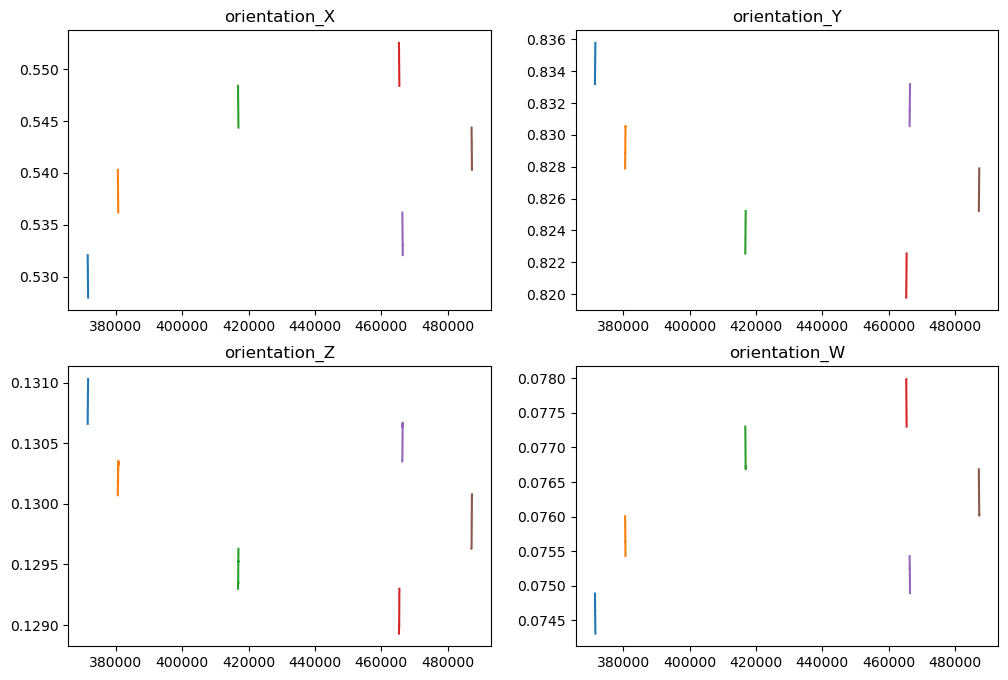

In [14]:
g = train.groupby(by = 'group_id')
g67 = g.get_group(67)
g67_g = g67.groupby('series_id')
f, axes = plt.subplots(2, 2, figsize = (12,8))
axs = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
orientations = ['orientation_X','orientation_Y','orientation_Z','orientation_W']
for name, group in g67_g:
    for ax,orientation in zip(axs,orientations):
        group[orientation].plot(label = name, ax=ax, title = orientation)

<a id='section4'></a>
# Stitching Time Series

Stiching time series is easy to do using the group_ids by simply matching the ends together. In the absence of a group_id, however, the problem becomes more interesting. It's not helpful to stitch the training series together unless I can do the same for the test set, so it's imperative to come up with a mechanism that can do it "blind", so to speak.

The first logical step is to find the possible matches that a series might have. This is easily done by comparing the ends of each series with those of every other series in a dataframe, and returning only those other series who are close (in all positions) to the chosen series. The "closeness" is a threshold that can be set by the user to select return more or fewer matches. The threshold is compared to the sum of the absolute differences between each position feature on the ends of both series.

Having a list of possible matches is helpful, but stitching requires that only one or zero matches be allowed. Given that this robot is a real device, we know that its motion will be contiguous and differentiable at all spots. A second function will check the contiguity and differentiability of the signals at the join. These will both be done through thresholds, since the data is discrete.

Finally, a subroutine wraps the positive and negative select functions and iterates through the entire dataframe in order to return correctly ordered lists of series to be stitched together. See the collapsed functions below for more information.

In [15]:
def find_matches(current_signal, df, in_front = True, threshold = 0.01):
    ## Returns a dataframe of the series ids, sums, and position (front/end) of the likely matches for the given front and end values.
    orientations = ['orientation_X','orientation_Y','orientation_Z','orientation_W']
    selection = ['series_id'] + orientations
    if in_front:
        end = current_signal.iloc[127][selection]
        front = df.loc[df.measurement_number ==0][selection]
    else:
        front = current_signal.iloc[0][selection]
        end = df.loc[df.measurement_number ==127][selection]
    compare = (front-end).abs()
    if in_front:
        compare.series_id = front.series_id
    else:
        compare.series_id = end.series_id
    compare['sums'] = compare[orientations].sum(axis=1)
    compare['in_front'] = in_front
    compare.drop(labels = orientations, axis = 1, inplace = True)
    compare.sort_values(by = 'sums', inplace = True)
    if any(compare.sums < threshold):
        return compare.loc[compare.sums < threshold], True
    else:
        return 0,False

In [16]:
def continuity(current_signal, compare_signal, in_front = True, merge_threshold = 4, slope_threshold = 6):
    orientations = ['orientation_X','orientation_Y','orientation_Z','orientation_W']
    select = ['series_id'] + orientations
    if in_front:
        end = current_signal[select]
        front = compare_signal[select]
    else:
        front = current_signal[select]
        end = compare_signal[select]
    stitched = pd.concat([end,front])
    diff = stitched.diff()
    
    # Check for continuity based on difference at merge point
    mean = diff[orientations].iloc[120:127].mean()
    std = diff[orientations].iloc[120:127].std()
    test = (diff[orientations].iloc[128]-mean)/std
    if any(test.abs() > merge_threshold):
        return False
    
    # Check for continuity based on slopes (t-test of means)
    slope_front = diff[orientations].iloc[120:127].mean()
    std_front = diff[orientations].iloc[120:127].std()
    var_front = std_front.apply(np.square)
    slope_end = diff[orientations].iloc[129:136].mean()
    std_end = diff[orientations].iloc[129:136].std()
    var_end = std_end.apply(np.square)
    t_value = (slope_front-slope_end)/(var_front/8+var_end/8).apply(np.sqrt)
    if any(t_value.abs() > slope_threshold):
        return False
    
    return True

In [17]:
def group_series(df, match_threshold = 0.01, continuity_thresholds = (4,6)):
    df_c = df.copy()
    # Create variables
    lookup_dictionary = {}
    new_group_id = -1
    l_init = len(df_c)
    t_start = time.time()
    # Cycle through df
    while len(df_c):
        # Give feedback with regard to end time
        t_elapsed = time.time()
        t_diff = t_elapsed-t_start
        l_now = len(df_c)
        frac_done = 1-(l_now/l_init)
        if frac_done > 0:
            ETA = t_diff/frac_done-t_diff
        else:
            ETA = 0
        message = 'Grouping Progress:{0:1.2f}%\tETA:{1:1.2f}min'.format(frac_done*100,ETA/60 )
        print(message, end='\r')
        # Add new group to lookup dictionary
        new_group_id +=1
        lookup_dictionary[new_group_id] = []
        # Start by selecting first available signal
        start_series = df_c.series_id.unique()[0]
        start_signal = df_c.loc[df_c.series_id==start_series]
        current_signal = start_signal
        # Add series to lookup dictionary
        lookup_dictionary[new_group_id].append(start_series)
        # Delete entry from df
        indices =  start_signal.index
        df_c.drop(indices,inplace = True)
        # Prepare to expand forwards and backwards
        expand_forward = True
        expand_backward = True
        # Expand signal forward first
        while (expand_forward) & (len(df_c)>0):
            candidates, match = find_matches(current_signal, 
                                             df_c, 
                                             in_front = True,
                                             threshold = match_threshold)
            continuity_tracker = []
            if match:
                for _,candidate in candidates.iterrows():
                    compare_signal = df_c.loc[df_c.series_id == candidate.series_id]
                    if continuity(current_signal, 
                                  compare_signal, 
                                  in_front = candidate.in_front,
                                  merge_threshold = continuity_thresholds[0],
                                  slope_threshold = continuity_thresholds[1]):
                        current_series = candidate.series_id
                        lookup_dictionary[new_group_id].append(current_series)
                        current_signal = df_c.loc[df_c.series_id==current_series]
                        df_c.drop(current_signal.index, inplace = True)
                        continuity_tracker.append(True)
                        break
                    else:
                        continuity_tracker.append(False)
                if any(continuity_tracker):
                    continue
                else: # If nothing passed the continuity check then stop expanding forward
                    expand_forward = False
            else: # If no candidates, then stop expanding forward
                expand_forward = False
            # Clean variable space
            del candidates,match
        # Expand signal backwards
        current_signal = start_signal
        while (expand_backward) & (len(df_c)>0):
            candidates, match = find_matches(current_signal, 
                                             df_c, 
                                             in_front = False,
                                             threshold = match_threshold)
            continuity_tracker = []
            if match:
                for _,candidate in candidates.iterrows():
                    compare_signal = df_c.loc[df_c.series_id == candidate.series_id]
                    if continuity(current_signal, 
                                  compare_signal, 
                                  in_front = candidate.in_front,
                                  merge_threshold = continuity_thresholds[0],
                                  slope_threshold = continuity_thresholds[1]):
                        current_series = candidate.series_id
                        lookup_dictionary[new_group_id].insert(0,current_series)
                        current_signal = df_c.loc[df_c.series_id==current_series]
                        df_c.drop(current_signal.index, inplace = True)
                        continuity_tracker.append(True)
                        break
                    else:
                        continuity_tracker.append(False)
                if any(continuity_tracker):
                    continue
                else: # If nothing passed the continuity check then stop expanding forward
                    expand_backward = False
            else: # If no candidates, then stop expanding forward
                expand_backward = False
            # Clean variable space
            del candidates, match
    print("Grouping Done                             ")
    print("Total Groups: {}".format(new_group_id))
    return lookup_dictionary

In [18]:
def stitch_series(df,ordered_series_array):
    osa = ordered_series_array
    g = df.groupby('series_id')
    sub_dfs = []
    for series in osa:
        temp_df = g.get_group(series)
        sub_dfs.append(temp_df)
    df_out = pd.concat(sub_dfs)
    df_out.measurement_number = list(range(0,len(df_out)))
    return df_out

In [19]:
def recast_df(df, match_threshold = 0.01, continuity_thresholds = (4,6)):
    lookup_dict = group_series(df, 
                               match_threshold=match_threshold, 
                               continuity_thresholds=continuity_thresholds)
    sub_dfs = []
    for key,group in lookup_dict.items():
        temp_df = stitch_series(df,group)
        temp_df['new_group_id'] = key
        sub_dfs.append(temp_df)
    stitched = pd.concat(sub_dfs)
    return stitched

In [20]:
stitched_train = recast_df(train, match_threshold=0.05, continuity_thresholds=(6,9))

Grouping Done                             
Total Groups: 104


In [21]:
stitched_train.tail()

,series_id,group_id,surface,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,new_group_id
371579,2902,67,wood,2902_123,763,0.52816,0.83568,0.13101,0.074345,-0.002012,0.005026,-0.003178,0.13637,2.8724,-9.3596,104
371580,2902,67,wood,2902_124,764,0.52816,0.83568,0.13102,0.074346,-0.002800,0.001101,-0.001736,0.12568,2.8726,-9.3911,104
371581,2902,67,wood,2902_125,765,0.52802,0.83577,0.13102,0.074321,0.000301,0.000331,0.005215,0.12300,2.8750,-9.3701,104
371582,2902,67,wood,2902_126,766,0.52801,0.83577,0.13102,0.074316,-0.001979,0.006680,-0.002159,0.12178,2.8537,-9.3755,104
371583,2902,67,wood,2902_127,767,0.52801,0.83577,0.13103,0.074308,0.000860,0.007261,-0.006326,0.10437,2.8534,-9.3663,104


Let's see what one of those stitched groups looks like, organized by surface like I did above.

In [22]:
@interact
def plot_stitched_signals(surface = surfaces, group = (1,10)):
    sub_stitched = stitched_train.loc[stitched_train.surface==surface]
    g = sub_stitched.groupby('new_group_id')
    group_id = list(g.groups.keys())[group]
    plt.figure(figsize = (12,18))
    signal = g.get_group(group_id)
    for i,feature in enumerate(features):
        ax = plt.subplot(5,2,i+1)
        ax.plot(signal['measurement_number'], signal[feature])
        ax.set_title(feature)
        ax.set_xlabel('Measurement Number')
        ax.set_ylabel('Magnitude')

interactive(children=(Dropdown(description='surface', options=('fine_concrete', 'concrete', 'soft_tiles', 'til…

Now I'll check to make sure that each new group in the stitched train dataframe is homogenous with regards to a surface, since they're homogenous with regards to a surface in the original train dataframe.

In [23]:
g = stitched_train.groupby('new_group_id')
surface_count = []
sample_count = []
for name, group in g:
    surfaces = group.surface.unique()
    surface_count.append(len(surfaces))
    sample_count.append(len(group))
print('Max Surface Count:{0}'.format(max(surface_count)))
print('Min Sample Count:{0}'.format(min(sample_count)))
print('Max Sample Count:{0}'.format(max(sample_count)))

Max Surface Count:1
Min Sample Count:256
Max Sample Count:17920


I have reason to believe that the stitching put together groups that didn't exist before. The longest group that was stitched is 17920 samples long (140 series). I'll check to see if the original dataset has a group with an equal number of samples

In [24]:
g = stitched_train.groupby('group_id')
sample_count = []
for name, group in g:
    surfaces = group.surface.unique()
    surface_count.append(len(surfaces))
    sample_count.append(len(group))
print('Max sample count in original groups:{0}'.format(max(sample_count)))

Max sample count in original groups:9088


My suspicion is confirmed. Long runs were themselves cut up into groups, which were further cut up into series. It is possible (and likely given the public kernels that leverage position as a predictor) that the test data was cut up from a long run that also includes train data, so I'll toss all of the data into one large dataframe and stitch it together. At worst, I'll have all of the data stitched. I can get rid of group_id and row_id since I won't be using those. I'll then make sure that series ids are unique between the groups, and merge the groups using "no_surface" as the surface for the unknown groups.

In [25]:
# Drop unnecessary columns from train, and add new columns to keep track of train/test
train.drop(['row_id','group_id'], axis = 1, inplace = True)
train['orig_id'] = train.series_id
train['test'] = 0
# Drop unnecessary columns from test, and add new columns as above
test.drop(['row_id'], axis = 1, inplace = True)
test['surface'] = 'no_surface'
test['orig_id'] = test.series_id
test['test'] = 1
test.series_id += train.series_id.max()+1

In [26]:
all_data = pd.concat([train,test], sort=False, ignore_index=True)

In [27]:
all_stitched = recast_df(all_data, match_threshold=0.05, continuity_thresholds=(9,9))

Grouping Done                             
Total Groups: 90


This is fewer total groups than stitching the training data! I did change the thresholds slightly, but even if the thresholds were kept the same the number of groups doesn't scale with the size of the dataframe. This indicates to me that some of the test data is part of runs that are present in the train data. I'll check the maximum and minimum sample counts, as well as the maximum surface count in a group.

In [28]:
g = all_stitched.groupby('new_group_id')
surface_count = []
sample_count = []
for name, group in g:
    surfaces = group.surface.unique()
    surface_count.append(len(surfaces))
    sample_count.append(len(group))
print('Max Surface Count:{0}'.format(max(surface_count)))
print('Min Sample Count:{0}'.format(min(sample_count)))
print('Max Sample Count:{0}'.format(max(sample_count)))

Max Surface Count:3
Min Sample Count:128
Max Sample Count:86528


There is at least one run that has more than two surfaces, which isn't great. I'll rerun the analysis, but this time I'll store the groups that are in error. I'll also reclassify data if there are two surfaces and one of the surfaces is "no_surface". This is the first classification that I'll perform in this hybrid classifier. Not all of the data will be classified now, but I suspect that a majority will be. I am assuming that an individual group represents only one surface almost all of the time.

In [29]:
g = all_stitched.groupby('new_group_id')
new_dfs = []
error_surfaces = []
error_group_ids = []
matched = 0
unmatched = 0
unmatched_ids = []
for name, group in g:
    surfaces = list(group.surface.unique())
    # If a group contains one known surface and a total of two surfaces, then reclassify the unknown data as appropriate
    if (len(surfaces)==2) & ('no_surface' in surfaces):
        surfaces.remove('no_surface')
        group['surface'] = surfaces[0]
        new_dfs.append(group)
        matched +=1
    # If a group contains two known surfaces then store it as a group "in error"    
    elif (len(surfaces)==2) & ('no_surface' not in surfaces):
        error_surfaces.append(surfaces)
        new_dfs.append(group)
    # If a group has three surfaces or more than store it as a group "in error"    
    elif (len(surfaces)>2):
        error_surfaces.append(surfaces)
        error_group_ids.append(name)
        new_dfs.append(group)
    # Else, increase the unmatched counter by one if there's only one surface and it's unknown
    else:
        new_dfs.append(group)
        if surfaces[0] == 'no_surface':
            unmatched += 1
            unmatched_ids.append(name)
# Make a new dataframe from reclassified data
sorted_data = pd.concat(new_dfs)
sorted_data.reset_index(inplace=True, drop = True)

In [30]:
print('Number of unmatched groups:{0}'.format(unmatched))

Number of unmatched groups:23


The good news is that there are only 23 unmatched groups. This significantly reduces the complexity of the problem, since I will assume that each group only represents one surface. The unmatched ids are 68:90. 
The bad news is that there were three groups that raised an error. All of the groups had more than two surfaces. My gut feeling is that they shouldn't have been stitched, though perhaps it's the case that the robot did meander from one surface to another in a meta-run. Those groups and their surfaces are shown below.

In [31]:
error_surfaces

[['concrete', 'no_surface', 'wood'],
 ['no_surface', 'concrete', 'carpet'],
 ['tiled', 'no_surface', 'wood']]

In [32]:
error_group_ids

[2, 9, 27]

I'll plot the groups by group_id and color by surface to better understand what's happening. The group ids above are the groups that are "in error", so it is worthwhile to examine those closely.

In [33]:
# Some groups take >2 mins to plot because of the number of available samples
@interact
def plot_grouped_data(group_id = (1,90)):
    g = all_stitched.groupby('new_group_id')
    plt.figure(figsize = (12,30))
    signal = g.get_group(group_id)
    for i,feature in enumerate(features):
        ax = plt.subplot(5,2,i+1)
        sns.lineplot(x = 'measurement_number',
                     y = feature,
                     data = signal, 
                     hue='surface', 
                     ax=ax);
        ax.set_title(feature)
        ax.set_xlabel('Measurement Number')
        ax.set_ylabel('Magnitude')

interactive(children=(IntSlider(value=45, description='group_id', max=90, min=1), Output()), _dom_classes=('wi…

It looks like I can safely manually assign surfaces to groups 2 and 9 based on the graphs above using the position data and a visual estimate of the RMS of the motion data. Talk about supervised learning... The function below helps me reassign surfaces.

In [34]:
def reassign_surfaces(new_surface_list, group_id, df):
    # Pull group from dataframe first
    error_group = df[sorted_data.new_group_id == group_id]
    reassign = {}
    start = 1
    end = 1
    segment = 0
    escape = 0 
    while escape == 0:
        # Find segments that are represented by one surface (do this recursively)
        temp_dict = {}
        surface = error_group.surface.iloc[0]
        start = error_group.first_valid_index()
        if len(error_group.surface.unique()) > 1:
            end = error_group.loc[error_group.surface != surface].first_valid_index()
        else:
            end = error_group.last_valid_index()
            escape = 1
        error_group.drop(range(start,end),inplace = True)
        
        #Store Data
        if surface == 'no_surface':
            temp_dict['surface'] = new_surface_list[segment]
            temp_dict['start'] = start
            temp_dict['end'] = end
            reassign[segment] = temp_dict
            segment += 1
    # Use data to reassign surfaces
    for key,value in reassign.items():
        df.iloc[value['start']:value['end'],1] = value['surface']
    
    fixed_group = df[sorted_data.new_group_id == group_id]
    plt.figure(figsize = (12,4))
    sns.lineplot(x = 'measurement_number',
                     y = 'orientation_X',
                     data = fixed_group, 
                     hue='surface');

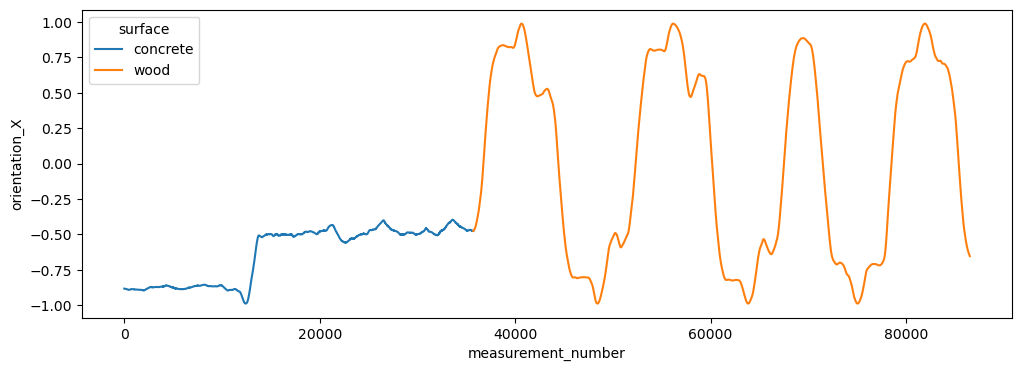

In [35]:
surface_2 = ['concrete','wood','wood']
reassign_surfaces(surface_2,2,sorted_data)

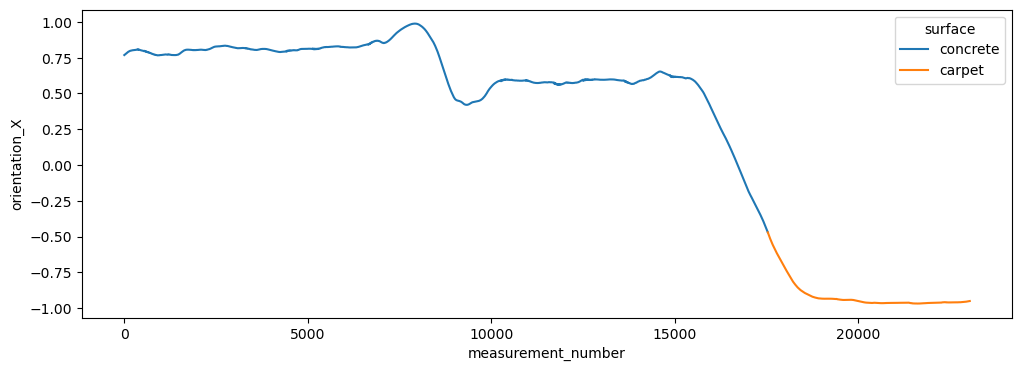

In [36]:
surface_9 = ['concrete', 'concrete']
reassign_surfaces(surface_9, 9, sorted_data)

It would be useful to export the current matches to make sure that I'm on track. I'll select the data and then come up with an estimate score to compare against.

In [37]:
output = sorted_data[sorted_data.test == 1][['orig_id','surface']].groupby('orig_id').max().reset_index()
output.to_csv(path_or_buf = 'preClassification.csv', 
              header = ['series_id','surface'], 
              index = False)
estimated_score = sum(output.surface!='no_surface')/len(output)

In [38]:
real_score = 0.55*0.6878 + 0.45*0.8175
print('Estimated Score: {0:1.3f}'.format(estimated_score))
print('Real Score: {0:1.3f}'.format(real_score))
print('Accuracy: {0:1.3f}'.format(real_score/estimated_score))

Estimated Score: 0.788
Real Score: 0.746
Accuracy: 0.947


Classifying the data by stitching groups together is 94.7% accurate. If I choose to accept this stitched and classified data, then I can do no better than ~96% accuracy on the final dataset because I have already misclassified 4% of the data. This is okay for now, though it's something I can improve on later.

<a id='section5'></a>
# Feature Extraction
The next step is to extract features from the signals in order to develop a series of classifiers to classify the remaining data. We've looked at some features above (RMS, PSD), but there are a wealth of other features that I can pull out that are likely meaningful. The package TSFRESH was developed to automate feature extraction and selection from time series data. Their work is published in [this paper linked here](https://www.sciencedirect.com/science/article/pii/S0925231218304843?via%3Dihub), and the packgage documentation is publicly available [here](https://tsfresh.readthedocs.io/en/latest/).

I will only be extracting features from the motion data, since its the only data that should have any predictive power. After all, the position of the robot shouldn't predict what surface it's on (it's not the case that robots only walk east on concrete, though that would make for an interesting story). The position data was exploited above since I knew that the training data was split from a series of longer runs (original groups) and suspected that the same was true for the test data. If I have time, I will analyze how well the model performs in the absence of knowledge from stitching the data. It makes sense to keep the data stitched, however, since it is reasonable to assume that the robot walks on the same surface for at least an extended period of time.

In any case, I'll extract the relevant features below. Open up the collapsed code to see which features I chose to extract.

In [39]:
extract_from = sorted_data.drop(['surface','test','new_group_id', 'orig_id']+orientations, axis = 1)
extract_from.head()

,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,5177,0,0.003953,0.031351,-0.086012,0.070510,2.8750,-9.3821
1,5177,1,0.003299,0.028777,-0.090271,0.091805,2.8709,-9.3610
2,5177,2,0.010289,0.032158,-0.086130,0.115780,2.8979,-9.3569
3,5177,3,0.003284,0.035404,-0.088382,0.087879,2.8695,-9.3584
4,5177,4,0.006005,0.038119,-0.084560,0.121400,2.8646,-9.3847


In [40]:
params = {'abs_energy':None,
          'absolute_sum_of_changes':None,
          'agg_autocorrelation':[{'f_agg':'var','maxlag':32}],
          'change_quantiles':[{'ql':0.25,'qh':0.75,'isabs':True, 'f_agg':'mean'},
                             {'ql':0.25,'qh':0.75,'isabs':True, 'f_agg':'std'}],
          'cid_ce':[{'normalize':True},{'normalize':False}],
          'fft_aggregated':[{'aggtype': 'centroid'},
                            {'aggtype': 'variance'},
                            {'aggtype': 'skew'},
                            {'aggtype': 'kurtosis'}],
          'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
          'standard_deviation': None,
          'variance': None,
          'skewness': None,
          'kurtosis': None,
          'maximum': None,
          'minimum': None,
          'sample_entropy':None,
          'mean_abs_change':None,
          'sum_values':None,
          'quantile': [{'q': 0.1},
                       {'q': 0.2},
                       {'q': 0.3},
                       {'q': 0.4},
                       {'q': 0.6},
                       {'q': 0.7},
                       {'q': 0.8},
                       {'q': 0.9}],
          'large_standard_deviation': [{'r': 0.25},{'r':0.35}],
          'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
                              {'coeff': 1, 'attr': 'real'},
                              {'coeff': 2, 'attr': 'real'},
                              {'coeff': 3, 'attr': 'real'},
                              {'coeff': 4, 'attr': 'real'},
                              {'coeff': 5, 'attr': 'real'},
                              {'coeff': 6, 'attr': 'real'},
                              {'coeff': 7, 'attr': 'real'},
                              {'coeff': 8, 'attr': 'real'},
                              {'coeff': 9, 'attr': 'real'},
                              {'coeff': 10, 'attr': 'real'},
                              {'coeff': 11, 'attr': 'real'},
                              {'coeff': 12, 'attr': 'real'},
                              {'coeff': 13, 'attr': 'real'},
                              {'coeff': 14, 'attr': 'real'},
                              {'coeff': 15, 'attr': 'real'},
                              {'coeff': 16, 'attr': 'real'},
                              {'coeff': 17, 'attr': 'real'},
                              {'coeff': 18, 'attr': 'real'},
                              {'coeff': 19, 'attr': 'real'},
                              {'coeff': 20, 'attr': 'real'},
                              {'coeff': 21, 'attr': 'real'},
                              {'coeff': 22, 'attr': 'real'},
                              {'coeff': 23, 'attr': 'real'},
                              {'coeff': 24, 'attr': 'real'},
                              {'coeff': 25, 'attr': 'real'},
                              {'coeff': 26, 'attr': 'real'},
                              {'coeff': 27, 'attr': 'real'},
                              {'coeff': 28, 'attr': 'real'},
                              {'coeff': 29, 'attr': 'real'},
                              {'coeff': 30, 'attr': 'real'},
                              {'coeff': 31, 'attr': 'real'},
                              {'coeff': 32, 'attr': 'real'},
                              {'coeff': 33, 'attr': 'real'},
                              {'coeff': 34, 'attr': 'real'},
                              {'coeff': 35, 'attr': 'real'},
                              {'coeff': 36, 'attr': 'real'},
                              {'coeff': 37, 'attr': 'real'},
                              {'coeff': 38, 'attr': 'real'},
                              {'coeff': 39, 'attr': 'real'},
                              {'coeff': 40, 'attr': 'real'},
                              {'coeff': 41, 'attr': 'real'},
                              {'coeff': 42, 'attr': 'real'},
                              {'coeff': 43, 'attr': 'real'},
                              {'coeff': 44, 'attr': 'real'},
                              {'coeff': 45, 'attr': 'real'},
                              {'coeff': 46, 'attr': 'real'},
                              {'coeff': 47, 'attr': 'real'},
                              {'coeff': 48, 'attr': 'real'},
                              {'coeff': 49, 'attr': 'real'},
                              {'coeff': 50, 'attr': 'real'},
                              {'coeff': 51, 'attr': 'real'},
                              {'coeff': 52, 'attr': 'real'},
                              {'coeff': 53, 'attr': 'real'},
                              {'coeff': 54, 'attr': 'real'},
                              {'coeff': 55, 'attr': 'real'},
                              {'coeff': 56, 'attr': 'real'},
                              {'coeff': 57, 'attr': 'real'},
                              {'coeff': 58, 'attr': 'real'},
                              {'coeff': 59, 'attr': 'real'},
                              {'coeff': 60, 'attr': 'real'},
                              {'coeff': 61, 'attr': 'real'},
                              {'coeff': 62, 'attr': 'real'},
                              {'coeff': 63, 'attr': 'real'},
                              {'coeff': 64, 'attr': 'real'}],
          
         }

While TSFRESH has a set of automated parameters that I could have used, they're not necessarilly tuned for this specific problem AND they return an absolutely massive dataframe that my Macbook Air can't handle. I chose these specific set of features based on my exploration of the data and my intuition on the motion of the robot.

TSFRESH is capable of selecting features for me by applying a series of hypothesis tests using the target (most of these tests are ANOVA, Fisher's test, or variants). I will allow it to tell me which features are most useful, though I'll likely use a combination of the reduced and full dataframes when I begin to create classifiers.

In [41]:
extracted_features = tsfresh.extract_features(extract_from,
                                              column_id='series_id',
                                              column_sort='measurement_number',
                                              n_jobs = 2, 
                                              default_fc_parameters = params)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [06:03<00:00, 36.35s/it]


In [42]:
efc = extracted_features.copy()
tsfresh.utilities.dataframe_functions.impute(efc)
y = all_stitched.groupby('series_id').max()['surface']
matched_y = y[y!='no_surface']
matched_ef = efc.iloc[matched_y.index]

In [43]:
features_filtered = tsfresh.select_features(matched_ef, matched_y)

In [44]:
feature_columns = features_filtered.columns

<a id='section6'></a>
# Classifier Exploration
The purpose of this section is to develop a set of classifiers that I can leverage for a hybrid classifier. It's only worthwhile to keep classifiers that are relatively accurate, but I'll have to explore a series of them in order to choose the best ones. I'll make a train/test (validate) set first in order to assess the classifiers. Then I'll dive headlong into the different kinds of classifiers that are available.

I will intentionally use the unclassified stitched data below to not introduce any extraneous noise into the classifiers. Once the classifiers are trained I can toss them the data that I have yet to classify.

In [45]:
metadata = all_stitched.groupby('series_id').max()[['surface','test','new_group_id', 'orig_id']]

In [46]:
filtered_extracted = metadata.join(extracted_features[feature_columns])

In [47]:
train_filtered = filtered_extracted[filtered_extracted.test == 0]
test_filtered = filtered_extracted[filtered_extracted.test == 1]

In [48]:
X_filtered = train_filtered.drop(labels = ['surface','test','new_group_id', 'orig_id'], 
                                 axis = 1)
y_filtered = train_filtered.surface

X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_filtered, y_filtered, test_size=0.25, random_state=42, stratify = y_filtered)

I'll also scale the data since this is helpful for some classifiers. I will have to keep track of whether or not the data that I'm using is scaled.

In [49]:
scaler_f = StandardScaler()
X_f_train_scaled = scaler_f.fit_transform(X_f_train)
X_f_test_scaled = scaler_f.transform(X_f_test)

The first classifier I'll test is the Random Forest Classifier. **I'll use the filtered extracted dataset without scaling.**

In [50]:
RFC = RandomForestClassifier(n_estimators=50, random_state = 42, n_jobs=-1)
RFC.fit(X_f_train, y_f_train)
y_f_test_RFC = RFC.predict(X_f_test)
print(classification_report(y_f_test, y_f_test_RFC))

                        precision    recall  f1-score   support

                carpet       0.72      0.28      0.40        47
              concrete       0.55      0.75      0.64       195
         fine_concrete       0.37      0.15      0.22        91
            hard_tiles       0.00      0.00      0.00         5
hard_tiles_large_space       0.63      0.51      0.56        77
              soft_pvc       0.63      0.84      0.72       183
            soft_tiles       0.80      0.91      0.85        74
                 tiled       0.52      0.39      0.44       129
                  wood       0.72      0.69      0.70       152

              accuracy                           0.62       953
             macro avg       0.55      0.50      0.50       953
          weighted avg       0.60      0.62      0.59       953



Now I'll check Naive Bayes. **I'll use the filtered and scaled data.**

In [51]:
NB = GaussianNB()
NB.fit(X_f_train_scaled, y_f_train)
y_test_NB = NB.predict(X_f_test_scaled)
print(classification_report(y_f_test, y_test_NB))

                        precision    recall  f1-score   support

                carpet       0.00      0.00      0.00        47
              concrete       0.65      0.10      0.18       195
         fine_concrete       0.23      0.18      0.20        91
            hard_tiles       0.05      1.00      0.10         5
hard_tiles_large_space       0.59      0.38      0.46        77
              soft_pvc       0.54      0.62      0.58       183
            soft_tiles       0.60      0.88      0.71        74
                 tiled       0.30      0.68      0.42       129
                  wood       0.53      0.31      0.39       152

              accuracy                           0.40       953
             macro avg       0.39      0.46      0.34       953
          weighted avg       0.48      0.40      0.38       953



How interesting. This one does better at predicting hard_tiles at the expense of predicting carpet. The scores aren't awful, but they're certainly not great.

Now perform linear SVC using a grid search. This grid search is small, so it runs fairly quickly. **I will use the filtered and scaled dataset for this.**

In [52]:
C_range = np.logspace(-4, 0, 4)
param_grid = dict(C=C_range)
SVM = GridSearchCV(SVC(kernel = 'linear'), 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    pre_dispatch=2, 
                    cv = 3)
SVM.fit(X_f_train_scaled, y_f_train)
y_test_svc = SVM.predict(X_f_test_scaled)
print(classification_report(y_f_test, y_test_svc))

                        precision    recall  f1-score   support

                carpet       0.43      0.38      0.40        47
              concrete       0.58      0.69      0.63       195
         fine_concrete       0.42      0.24      0.31        91
            hard_tiles       0.50      0.20      0.29         5
hard_tiles_large_space       0.58      0.43      0.49        77
              soft_pvc       0.60      0.77      0.67       183
            soft_tiles       0.74      0.89      0.81        74
                 tiled       0.53      0.47      0.49       129
                  wood       0.61      0.51      0.56       152

              accuracy                           0.58       953
             macro avg       0.55      0.51      0.52       953
          weighted avg       0.57      0.58      0.57       953



Now perform KNN **using the filtered and scaled data**.

In [53]:
KNN = KNeighborsClassifier(10)
KNN.fit(X_f_train_scaled,y_f_train)
y_test_knn = KNN.predict(X_f_test_scaled)
print(classification_report(y_f_test, y_test_knn))

                        precision    recall  f1-score   support

                carpet       0.40      0.17      0.24        47
              concrete       0.56      0.71      0.63       195
         fine_concrete       0.40      0.15      0.22        91
            hard_tiles       1.00      0.20      0.33         5
hard_tiles_large_space       0.59      0.44      0.50        77
              soft_pvc       0.60      0.82      0.69       183
            soft_tiles       0.67      0.89      0.77        74
                 tiled       0.46      0.36      0.40       129
                  wood       0.66      0.62      0.64       152

              accuracy                           0.58       953
             macro avg       0.59      0.49      0.49       953
          weighted avg       0.56      0.58      0.55       953



Check a regular decision tree **using the filtered, scaled data**

In [54]:
DT = DecisionTreeClassifier()
DT.fit(X_f_train_scaled,y_f_train)
y_test_dt = DT.predict(X_f_test_scaled)
print(classification_report(y_f_test, y_test_dt))

                        precision    recall  f1-score   support

                carpet       0.39      0.40      0.40        47
              concrete       0.49      0.45      0.47       195
         fine_concrete       0.22      0.29      0.25        91
            hard_tiles       0.50      0.20      0.29         5
hard_tiles_large_space       0.45      0.44      0.44        77
              soft_pvc       0.60      0.58      0.59       183
            soft_tiles       0.80      0.82      0.81        74
                 tiled       0.32      0.33      0.32       129
                  wood       0.59      0.57      0.58       152

              accuracy                           0.49       953
             macro avg       0.48      0.45      0.46       953
          weighted avg       0.49      0.49      0.49       953



And finally, perform XGBoost **on the filtered and scaled data.**

In [55]:
param_grid = {
    'max_depth': [3,4,5,6],  # the maximum depth of each tree
    'min_child_weight':np.linspace(0.8,1.2,4),
    'gamma': np.linspace(0,0.2,4),
}

In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_f_train_en = le.fit_transform(y_f_train)

In [57]:
import xgboost as xgb
# The below parameters were found using GridSearchCV, using the parameter search basis above.
XGB = xgb.sklearn.XGBClassifier(learning_rate = 0.025,
                                objective = 'multi:softmax',
                                n_estimators = 150,
                                max_depth = 5,
                                min_child_weight = 1.2,
                                subsample=0.8,
                                colsample_bytree = 0.8,
                                gamma = 0.066,
                                n_jobs = 4,
                                nthreads = 1,
                                silent = True,
                                seed = 42)
XGB.fit(X_f_train_scaled,y_f_train_en)
y_test_XGB = XGB.predict(X_f_test_scaled)
y_test_XGB = le.inverse_transform(y_test_XGB)
print(classification_report(y_f_test, y_test_XGB))

[17:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "nthreads", "silent" } are not used.

                        precision    recall  f1-score   support

                carpet       0.50      0.19      0.28        47
              concrete       0.58      0.76      0.66       195
         fine_concrete       0.47      0.15      0.23        91
            hard_tiles       0.00      0.00      0.00         5
hard_tiles_large_space       0.66      0.52      0.58        77
              soft_pvc       0.61      0.86      0.71       183
            soft_tiles       0.85      0.89      0.87        74
                 tiled       0.59      0.49      0.53       129
                  wood       0.69      0.64      0.66       152

              accuracy                           0.63       953
             macro avg       0.55      0.50      0.50       953
          weighted avg

<a id='section7'></a>
# Meta Ensemble Classifier
The real utility in stitching groups together is the ability to classify the entire group as one surface based on the results of classifying its constituent series. The easiest way to think of this is that the series vote on the classification of the group. The surface with the most "votes" is used to classify the entire group, similar to how RFC methods work. Furthermore, the results of each classifier above can be used in order to determine the votes for a group! Since the voting occurs as a sum of the number of instances that each surface appears in a group, each classifier can be assigned a relative weight in the voting schema. I'll employ this method to classify the remaining data.

First I'll make a function that generates and joins predictions from the classifier instances.

In [58]:
def get_predictions(filtered_data, classifiers, scaler):
    warnings.filterwarnings("ignore")
    
    df = filtered_data[['surface','test','new_group_id', 'orig_id']]
    X = filtered_data.drop(labels = ['surface','test','new_group_id','orig_id'], 
                                 axis = 1).values
    X_scaled = scaler.transform(X)
    for name, classifier_dict in classifiers.items():
        clf = classifier_dict['classifier']
        if classifier_dict['scale']:
            prediction = clf.predict(X_scaled)
        else:
            prediction = clf.predict(X)
        df[name] = prediction
    warnings.resetwarnings()
    return df

In [59]:
classifiers = {'RFC':{'classifier':RFC,'scale': False},
               'NB':{'classifier':NB,'scale':True},
               'SVM':{'classifier':SVM,'scale':True},
               'KNN':{'classifier':KNN,'scale':True},
               'DT':{'classifier':DT,'scale':True},
               'XGB':{'classifier':XGB,'scale':True}}

In [60]:
multi_predictions = get_predictions(filtered_data=train_filtered,
                              classifiers=classifiers, 
                              scaler=scaler_f)

The classifier-specific predictions can be used in an ensemble classifier function that is written below. The function accepts the predictions and a dictionary that includes the classifiers to use and their weights.

In [61]:
def classifier_ensemble(predictions, classifier_weights, groupby = 'new_group_id'):
    warnings.filterwarnings("ignore")
    df = predictions[['test','new_group_id','orig_id']]
    df['surface'] = 'None'
    g = predictions.groupby(groupby)
    for name, group in g:
        index = group.index
        weighted_value_counts = []
        for classifier,weight in classifier_weights.items():
            value_counts = group[classifier].value_counts()
            weighted_value_counts.append(value_counts*weight)
        all_counts = pd.DataFrame(weighted_value_counts).fillna(value=0)
        surface = all_counts.sum().sort_values(ascending=False).index[0]
        df.loc[index,'surface'] = surface
    warnings.resetwarnings()
    return df

In [62]:
classifier_weights = {classifier:1 for classifier in classifiers.keys()}
del classifier_weights['NB'] # Naive Bayes classification wasn't great, so I won't include it
ensemble_prediction = classifier_ensemble(predictions=multi_predictions,
                                 classifier_weights=classifier_weights)

In [63]:
print(classification_report(train_filtered.surface, ensemble_prediction.surface))

                        precision    recall  f1-score   support

                carpet       1.00      0.77      0.87       189
              concrete       0.92      0.79      0.85       779
         fine_concrete       1.00      1.00      1.00       363
            hard_tiles       1.00      1.00      1.00        21
hard_tiles_large_space       1.00      1.00      1.00       308
              soft_pvc       1.00      1.00      1.00       732
            soft_tiles       1.00      1.00      1.00       297
                 tiled       0.99      1.00      0.99       514
                  wood       0.78      0.98      0.87       607

              accuracy                           0.94      3810
             macro avg       0.97      0.95      0.95      3810
          weighted avg       0.95      0.94      0.94      3810



I'll have to perform my own parameter search on the classifier ensemble in order to find the weights that produce the best results. Using a grid approach might not be the best course of action since there are 5 parameters to set. Instead, I'll use an evolutionary algorithm with a maximum number of generations.

In [64]:
def CEParamSearch(y_true, multi_predictions, classifier_names, 
                  groupby = 'new_group_id', generations = 20, 
                  seed = 1, mutation_rate = 0.35):  
    # Generate random weights first
    np.random.seed(seed)
    weights = np.random.rand(len(classifiers))
    classifier_weights = {classifier:weight for classifier,weight in zip(classifier_names,weights)}
    
    # Classify the data and calculate a score with the weights
    ensemble_prediction = classifier_ensemble(multi_predictions,classifier_weights,groupby=groupby)
    y_pred = ensemble_prediction.surface
    score = sum(y_pred == y_true)/len(y_pred)
    
    # Keep track of score and time
    scores = [score]
    start = time.time()
    
    
    # Hunt for a better solution
    gene = random.choice(classifier_names)
    orig_mut_rate = mutation_rate
    for generation in range(1,generations+1):
        # Make new weights using small mutation
        new_weights = classifier_weights
        mutation = (np.random.rand(1)-0.5)*mutation_rate
        
        new_weights[gene] += mutation
        #Constrain weights to [0,1]
        if new_weights[gene] < 0:
            new_weights[gene] = 0
        if new_weights[gene] > 1:
            new_weights[gene] = 1
            
        # Classify data and obtain new score
        ensemble_prediction = classifier_ensemble(multi_predictions,new_weights,groupby=groupby)
        y_pred = ensemble_prediction.surface
        new_score = sum(y_pred == y_true)/len(y_pred)
        change = new_score - score
        # Select fittest weights
        if change < 0: # If new score is worse change the gene, reestablish mutation rate
            scores.append(score)
            gene = random.choice(classifier_names)
            mutation_rate = orig_mut_rate
        elif change == 0: # Mutate, but don't change gene or the mutation rate
            scores.append(score)
            classifier_weights = new_weights
        elif change > 0: # Mutate and change mutation rate, but don't change the gene
            mutation_rate /= 0.75
            score = new_score
            scores.append(score)
            classifier_weights = new_weights
        
        # Update User
        progress = generation/generations
        time_elapsed = (time.time()-start)
        ETA = (time_elapsed/progress-time_elapsed)/60
        print('Score:{0:1.5f}\t|\tChange:{1:1.5f}\t|\tTime Remaining: {2:1.2f} min'.format(score,change,ETA), end = '\r')
    
    plt.plot(scores)
    return classifier_weights

In [65]:
classifier_names = list(classifier_weights.keys())

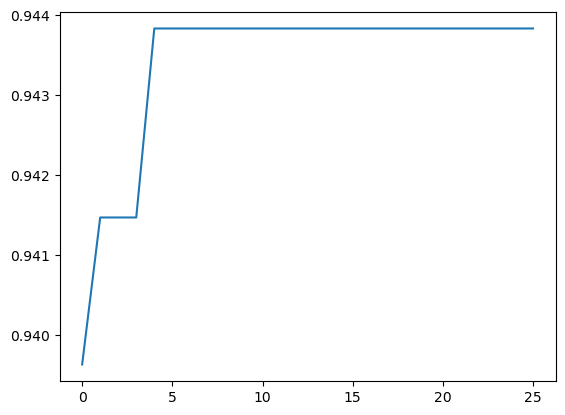

In [66]:
classifier_weights = CEParamSearch(train_filtered.surface,
                                   multi_predictions,
                                   classifier_names, 
                                   generations = 25,
                                   mutation_rate = 0.5,
                                   seed = 40)

The results of CEParamSearch are random, though they do tend towards optimization as you can see in the graph above. The classifier weights below were used for a late submission whose public and private score I reveal below.

In [67]:
classifier_weights = {'RFC': 1,
 'SVM': 1,
 'KNN': 0,
 'DT': 0.22006725,
 'XGB': 0.38377276}

Now that I have an optimized set of classifier weights I will run the unclassified dataset through the ensemble classifier to check its performance against Kaggle.

In [68]:
multi_predictions_test = get_predictions(test_filtered,classifiers,scaler_f)

In [69]:
ensemble_prediction_test = classifier_ensemble(predictions=multi_predictions_test,
                                 classifier_weights=classifier_weights)

In [70]:
output = ensemble_prediction_test[['orig_id','surface']].reset_index().drop('series_id', axis =1)
output.to_csv(path_or_buf = 'Ensemble_Classified.csv', 
              header = ['series_id','surface'], 
              index = False)

A private score of 0.8280 and a public score of 0.4656 is good given that I'm not leveraging all of the position data. The public score mostly benefits from the position matched data.

<a id='section8'></a>
# Hybrid Classification
It's unfair to say that the previous ensemble classification was not a hybrid classification already. Hybrid classifiers are those that classify over multiple iterations, rather than classifying by comparing the output of different processes. The above ensemble classification was built on the existing classification that was done to select features, and the classification to find groups. This following hybrid classification leverages all of that information to its extreme. I will accept the classification that was applied after finding groups, use the classified features to obtain outputs from individual classifiers, classify the remaining unclassified data using the ensemble classifier I generated, and finally stitch the position matched classification with the ensemble matched classification.

In [71]:
metadata = sorted_data.groupby('series_id').max()[['surface','test','new_group_id', 'orig_id']]
filtered_extracted_matched = metadata.join(extracted_features[feature_columns])
unmatched_filtered = filtered_extracted_matched[filtered_extracted_matched.surface == 'no_surface']

In [72]:
multi_predictions_unmatched = get_predictions(unmatched_filtered, classifiers, scaler_f)
ensemble_prediction_unmatched = classifier_ensemble(multi_predictions_unmatched, classifier_weights)
unmatched_output = ensemble_prediction_unmatched[['orig_id','surface']].reset_index().drop('series_id', axis =1)

In [73]:
matched_output = metadata[(metadata.test == 1)&(metadata.surface != 'no_surface')][['orig_id','surface']].reset_index().drop('series_id', axis =1)

In [ ]:
os.chdir("/kaggle/working/")

In [74]:
output = pd.concat([matched_output,unmatched_output])
output.to_csv('Hybrid_Classified.csv', 
              header = ['series_id','surface'], 
              index = False)

The results of the Kaggle submission are wonderful! **A private score of 0.8777 and a public score of 0.9876 yields a combined accuracy of 0.9272 on the whole dataset.** We already know that ~4% of the data was misclassified after the groups were stitched, so only about ~3% of the remaining unclassified data was misclassified by the meta ensemble classifier. Overall, I'm thrilled with this score! To improve these scores I could tune all of the individual classifiers, search for more features to extract, and improve and the grouping mechanism.

<a id='section9'></a>
# Conclusion

The hybrid classifier that I developed was clearly better than using classical or ensemble classification schemes by themselves. Even a meta-ensemble of the standard classification schemes significantly outperforms a single classification scheme, which is helpful knowledge for future classification problems. Building this meta-classifier is simple enough, and tuning its performance even for a large number of parameters can be done using an evolutionary approach.